In [11]:
import pandas as pd
import numpy as np
import pickle
import time 
import os
from datetime import datetime
from operator import itemgetter
import time

# 需要什么读取什么不要一次性全都读取了，影响程序速度

data_folder_path = '../'
raw_data_path = "../raw_data"
storage_path = "../database_storage"
daily_path = "../daily"
DTBS_path = os.path.join(storage_path, "DTBS.pkl")
DCBS_path = os.path.join(storage_path, "DCBS.pkl")

with open('database_ByZCG\\DCBS_DataFrame.pkl', 'rb') as f: 
    DCBS_DataFrame = pickle.load(f)
    
with open('database_ByZCG\\DTBS_DataFrame.pkl', 'rb') as f:  
    DTBS_DataFrame = pickle.load(f)

# 只提取A区中存活的转债的时间序列信息
A_DF = DTBS_DataFrame['A']
A_DF = A_DF[A_DF['ia']==1].copy()

C_DF = DTBS_DataFrame['C'].copy()
D_DF = DTBS_DataFrame['D'].copy()

# 计算所有转债每天的涨跌幅，并找出涨幅大于前N个交易日的q分位数涨跌幅的均值的转债

In [2]:
# ----------------------------------------------------------------------------------------------------------------------
# 下面这些代码的核心功能是回测    ->    利用上面生成的持仓表去实现换仓，计算收益等各类指标
# ----------------------------------------------------------------------------------------------------------------------


# 回测(这是简易版的不考虑持仓情况，姚芊芊需要的算法)，可以修改持仓EXCEL表格
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import sqrt,log
from numpy import std

# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题


# -------------------------------------------------------------------------------------------------------------------------------------------
# 下面的三个函数是真正实现回测功能的    ->   理论上只要传入合适的参数，可以重复使用，对于不同的策略都不需要修改 
# -------------------------------------------------------------------------------------------------------------------------------------------


# 获取一段时间内等转债份额买入的收益率
def get_period_profit(trade_dates_list, my_position, A_DF):
    profit = []
    for trade_date_index in range(1,len(trade_dates_list)):    
        trade_date = trade_dates_list[trade_date_index]
        last_trade_date = trade_dates_list[trade_date_index-1]

        # 本周期内持有的转债代码，应该是上周期末时换仓买入并持有到本周期末
        codes_list = my_position[last_trade_date]
        if codes_list == []:
            
            profit.append(0)
        else:    
            last_trade_date_all_bond_price_list = list(A_DF.loc[(A_DF.bond_code.isin(codes_list)) & (A_DF['date'] == last_trade_date),'dp'])
            last_trade_date_all_bond_price_sum = sum(last_trade_date_all_bond_price_list)

            trade_date_all_bond_price_list = list(A_DF.loc[(A_DF.bond_code.isin(codes_list)) & (A_DF['date'] == trade_date),'dp'])
            trade_date_all_bond_price_sum = sum(trade_date_all_bond_price_list)

            profit.append(trade_date_all_bond_price_sum / last_trade_date_all_bond_price_sum - 1)
            
    return(profit)


def display(profit, trade_dates_list, C_DF, photo_title, tick_spacing = 10):
    
    # x轴
    x = trade_dates_list[1:]
    
    # 图片名
    photo_title = trade_dates_list[0] + ' 至 ' + trade_dates_list[-1] + '  ' + photo_title
    
    # 获取中证转债指数列表
    zi_df = C_DF[C_DF['date'].isin(trade_dates_list)][['date','zi']].copy()
    zi_df.sort_values('date', ascending=True, inplace=True)
    zi = list(zi_df['zi'])    
    zi_cumulative_return = [zi[index]/zi[0] - 1 for index in range(1, len(zi))]
    zi_weekly_return = [zi[index]/zi[index-1] - 1 for index in range(1,len(zi))]
    
    # 获取累计收益率
    weekly_return = profit
    cumulative_return = []
    
    cr = 1
    for i in profit:
        cr = cr * (i + 1)
        cumulative_return.append(cr - 1)
        
    print('单周收益率：', weekly_return, '\n', '累积收益率：',cumulative_return, 
          '\n用累加算法算出的策略累计收益率：',sum(weekly_return), '\n用累加算法算出的中证转债累计收益率：', sum(zi_weekly_return))
    
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, cumulative_return, color='red', label="策略累计净收益率",linewidth=1)
    plt.plot(x, zi_cumulative_return, color='green', label="中证转债累计净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(30,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    plt.plot(x, weekly_return, color='red', label="策略单周净收益率",linewidth=1)
    plt.plot(x, zi_weekly_return, color='green', label="中证转债单周净收益率",linewidth=1)
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend()
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    # 显示图像
    plt.show()
    
    return weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return

def get_all_profit(profit, trade_dates_list, C_DF , photo_title, tick_spacing = 10):
    """这个函数就是display函数的简化版，去除了绘图功能"""
    # x轴
    x = trade_dates_list[1:]
        
    # 获取中证转债指数列表
    zi_df = C_DF[C_DF['date'].isin(trade_dates_list)][['date','zi']].copy()
    zi_df.sort_values('date', ascending=True, inplace=True)
    zi = list(zi_df['zi'])    
    zi_cumulative_return = [zi[index]/zi[0] - 1 for index in range(1, len(zi))]
    zi_weekly_return = [zi[index]/zi[index-1] - 1 for index in range(1,len(zi))]
    
    # 获取累计收益率
    weekly_return = profit
    cumulative_return = []
    
    cr = 1
    for i in profit:
        cr = cr * (i + 1)
        cumulative_return.append(cr - 1)
        
    return weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return

def calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return):
    # 用于获取各类指标
    
    # 周期
    print('周期：', trade_dates_list[0], '至', trade_dates_list[-1])
        
    # 获取策略累计收益率 my_cumulative_return
    my_cumulative_return = cumulative_return[-1]
    print('策略累计收益率：', my_cumulative_return)
    
    # 获取中证转债累计收益率 zzzz_cumulative_return
    zzzz_cumulative_return = zi_cumulative_return[-1]
    print('中证转债累计收益率：', zzzz_cumulative_return)
    
    # 统计胜率1（收益率大于0的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_one = len([i for i in weekly_return if i > 0]) / len([i for i in weekly_return if i != 0])
    print('胜率1（收益率大于0的比例）：', win_rate_one)
    
    # 统计胜率2（收益率高于中证转债指数的比例）,统计的时候应该去除收益率列表中的0值再进行计算，因为那些周期内没有合适的转债买入因此我们选择空仓
    win_rate_two = len([i for i in range(len(weekly_return)) if (weekly_return[i] > zi_weekly_return[i]) & (weekly_return[i] != 0)]) / len([i for i in weekly_return if i != 0])
    print('胜率2（收益率高于中证转债指数的比例）：', win_rate_two)
    
    # 年化夏普比率，下面这三个的算法不确定，需要确认
    # rf为无风险收益率（10年期国债，暂时取2.684%，这个需要随着时间改动）
    rf = 0.027 / 52    
    avg_rate = np.mean(weekly_return)
    std_rate = np.std(weekly_return)
    sharp_ratio = ((avg_rate - rf) / std_rate) * sqrt(52)
    print('夏普比率：',sharp_ratio)
    
    
    # 最大回撤 max_drawdown
    max_drawdown = 0
    cumulative_return_list = cumulative_return
    cumulative_return_list.insert(0,0)
    for i in range(1,len(cumulative_return_list)):
        temp = (max(cumulative_return_list[0:i]) - cumulative_return_list[i])/(1 + max(cumulative_return_list[0:i]))
        if max_drawdown < temp:
            max_drawdown = temp                
    print('最大回撤：',max_drawdown)   
    
    # 年化波动率
    log_return_list = [log(i+1) for i in weekly_return]
    Volatility = std(log_return_list) / sqrt(5)
    annualVolatility = Volatility * sqrt(252) 
    print('年化波动率：',annualVolatility)
    
    
    
    # 收益最好的一周
    print('收益率最好的一周：',trade_dates_list[weekly_return.index(max(weekly_return))],'至',trade_dates_list[weekly_return.index(max(weekly_return)) + 1])
    
    # 最高单周收益率
    print('最高单周收益率',max(weekly_return))
    
    # 收益最差的一周
    print('收益率最差的一周：',trade_dates_list[weekly_return.index(min(weekly_return))],'至',trade_dates_list[weekly_return.index(min(weekly_return)) + 1])
    
    # 最低单周收益率
    print('最低单周收益率',min(weekly_return))


# 这个函数的功能是用于绘制不同策略收益对比图
def display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略累计收益对比图', tick_spacing = 10):    
    # x轴
    x = trade_dates_list[1:]
           
    # 绘制累计净收益率曲线图
    plt.figure(figsize=(40,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    
    plt.plot(x, zi_cumulative_return, label="中证转债",linewidth=1)
    
    for name,my_dict in profit_dict.items():
        my_weekly_return = my_dict['weekly_return']
        my_cumulative_return = my_dict['cumulative_return']
        plt.plot(x, my_cumulative_return, label = name,linewidth=1)
        
    plt.xlabel("时间")
    plt.ylabel("累计收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    
    # 调整绘图区边距，确保图例和刻度完整显示
    plt.subplots_adjust(right=0.8,bottom=0.25)
    
    plt.savefig('result_photo\\各策略累计收益对比图.png')
    # 显示图像
    plt.show()
    
    # 绘制单周净收益率曲线图
    plt.figure(figsize=(40,15),dpi=1200)
    fig, ax = plt.subplots(1, 1)
    
    plt.plot(x, zi_weekly_return, label="中证转债",linewidth=1)
    for name,my_dict in profit_dict.items():
        my_weekly_return = my_dict['weekly_return']
        my_cumulative_return = my_dict['cumulative_return']
        plt.plot(x, my_weekly_return, label = name,linewidth=1)
    
    plt.xlabel("时间")
    plt.ylabel("单周收益率")
    plt.title(photo_title)
    # 图例显示
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # 设置打印的密度
    # tick_spacing = 1
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # 设置显示字体的大小
    plt.tick_params(axis='both', labelsize=10)
    # 对x轴进行翻转，竖向显示
    plt.xticks(rotation=90, fontsize=10)
    
    # 调整绘图区边距，确保图例和刻度完整显示
    plt.subplots_adjust(right=0.8,bottom=0.25)
    
    plt.savefig('result_photo\\各策略单周收益对比图.png')
    # 显示图像
    plt.show()

In [56]:
# -------------------------------------------------------------------------------------------------------------------------------------------
# 下面都是准备工作    ->    核心功能是生成：理论的持仓字典my_position（Key是日期，Value是转债代码的列表）、trade_dates_list（交易日期的列表）
# -------------------------------------------------------------------------------------------------------------------------------------------

"""
原始的条件，留个备份
drop_st_my_position_df = drop_st_my_position_df[(drop_st_my_position_df['剩余期限（年）'] >= 0.5) & 
                                                (110 <= drop_st_my_position_df['价格（收盘价全价）']) & 
                                                (drop_st_my_position_df['价格（收盘价全价）'] <= 135) &
                                                (drop_st_my_position_df['债券余额（亿）'] <= 7) &
                                                (drop_st_my_position_df['转股溢价率'] >= 0.05) & 
                                                (drop_st_my_position_df['涨跌幅'] <= 0.02) &
                                                (0 <= drop_st_my_position_df['涨跌幅'])
                                                ].copy()
"""

my_position_df = pd.read_excel('pre_data_for_backtest\\热门可转债+双低（全量数据DTBS，预处理）.xlsx')

# 删除掉ST和*ST股的持仓，
drop_st_my_position_df = my_position_df[~my_position_df['正股名称'].str.contains("ST")]

# 剔除掉剩余期限过短的转债，根据其他条件筛选掉一些转债
drop_st_my_position_df = drop_st_my_position_df[(drop_st_my_position_df['剩余期限（年）'] >= 1) & 
                                                (115 <= drop_st_my_position_df['价格（收盘价全价）']) & 
                                                (drop_st_my_position_df['价格（收盘价全价）'] <= 135) &
                                                (drop_st_my_position_df['债券余额（亿）'] <= 7) &                                                
                                                (drop_st_my_position_df['转股溢价率'] >= 5) & 
                                                (drop_st_my_position_df['涨跌幅'] <= 0.02)
                                                ].copy()

drop_st_my_position_df.to_excel('pre_data_for_backtest\\热门可转债+双低（全量数据DTBS，用于回测）.xlsx',index=False)

In [12]:
def get_my_position(name, start_day, end_day, which_day, D_DF):
    """这个函数的功能是从持仓表中获得标准化的持仓字典，将数据进一步标准化"""
    my_position_df = pd.read_excel('pre_data_for_backtest\\'+ name)
    
    # trade_dates_list 设置调仓日期固定为每周几
    trade_dates_list = list(D_DF.loc[(D_DF['date'] >= start_day)&(D_DF['date'] <= end_day)&(D_DF['which_day'] == which_day), 'date'])
    
    my_position = {date : list(my_position_df.loc[my_position_df['日期'] == date,'可转债代码']) for date in  trade_dates_list}
    
    return my_position, trade_dates_list

单周收益率： [0.008091914842497827, 0.012828759813453106, 0.016319876027054647, -0.001475433843450058, 0.0003632011825831505, 0.002605917498609056, 0.004457980616092039, 0.11838645803324943, 0.004260456253180722, -0.002684022050219226, -0.002410792601880263, 0.01465750817024003, 0.014453522735738744, 0.0057984391442229555, 0.013164068472135027, 0.0018567351804357202, 0.00189648550028787, -0.0008136569455767795, -0.00350451519073236, -0.011639012316910335, -0.014522459582972824, 0.0349742118594929, -0.01776120549648663, -0.016421950261208518, 0.02921872124644742, 0.001994642548533987, -0.012796955213311922, -0.0005347798550436877, 0.03473159895173472, -0.012748692326271516, -0.01633529632356001, -0.008600756386092367, 0.006029201364686765, 0.00516743412500853, 0.01447871962767966, -0.00740805046734383, 0.005064885134645758, -0.013504140626564465, -0.005509708287743664, 0.011231453951406456, 0.022212717767923218, -0.007986889445627199, 0.012149427825665304, -0.002888363731846866, 0.00016537915

<Figure size 36000x18000 with 0 Axes>

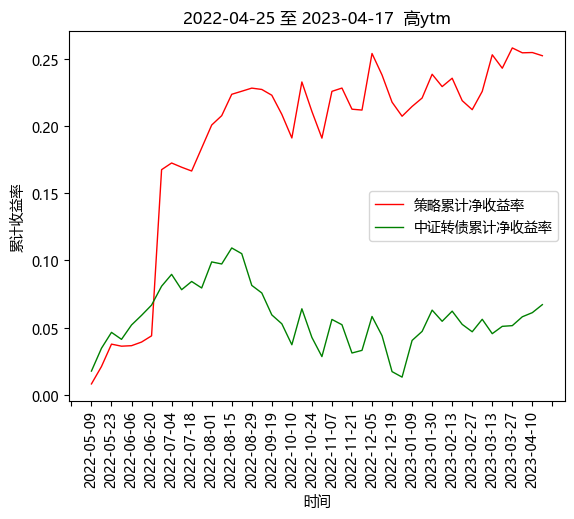

<Figure size 36000x18000 with 0 Axes>

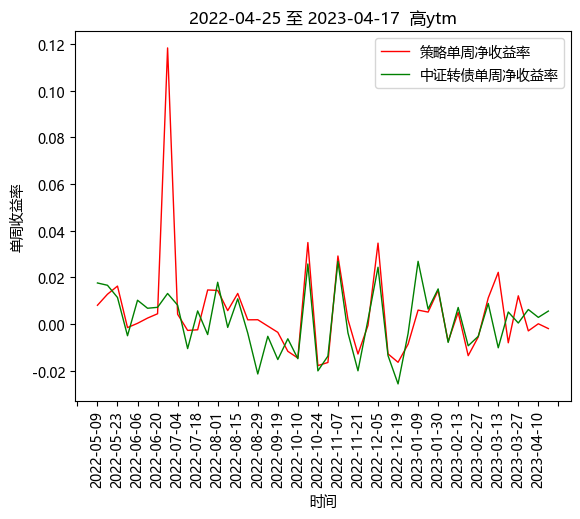

周期： 2022-04-25 至 2023-04-17
策略累计收益率： 0.25220183741509183
中证转债累计收益率： 0.0670620289140682
胜率1（收益率大于0的比例）： 0.5652173913043478
胜率2（收益率高于中证转债指数的比例）： 0.5217391304347826
夏普比率： 1.575672638001038
最大回撤： 0.03722813820697869
年化波动率： 0.14355803240387174
收益率最好的一周： 2022-06-20 至 2022-06-27
最高单周收益率 0.11838645803324943
收益率最差的一周： 2022-10-17 至 2022-10-24
最低单周收益率 -0.01776120549648663
程序运行时间：5.22秒


In [13]:
"""
# 回测所有的策略
names_and_which_day = [('低价小市值5（全量数据DTBS，用于回测）.xlsx', 'mon'), 
                       ('高ytm（全量数据DTBS，用于回测）.xlsx', 'wed'), 
                       ('区间双低3（全量数据DTBS，用于回测）.xlsx', 'thu'), 
                       ('双低5（全量数据DTBS，用于回测）.xlsx', 'thu'), 
                       ('小市值3双低5（全量数据DTBS，用于回测）.xlsx', 'wed'),
                       ('热门可转债+双低（全量数据DTBS，用于回测）.xlsx', 'mon'),
                       ('低价5（全量数据DTBS，用于回测）.xlsx', 'mon'),
                       ('热门可转债+低价程度（全量数据DTBS，用于回测）.xlsx', 'mon')]
# 跑多个回测周期
test_day_list = [('2021-07-01','2021-12-31'),('2022-01-01','2022-06-30'),('2022-07-01','2022-12-31'), ('2023-01-01','2023-06-30')]
"""
start_time = time.time()

# 回测单个策略（这样速度更快）
names_and_which_day = [('高ytm（全量数据DTBS，用于回测）.xlsx', 'mon')]
test_day_list = [('2022-04-20','2023-04-19')]



for start_day,end_day in test_day_list: 
    for name,which_day in names_and_which_day: 
        """两层循环是为了实现一次性回测多个策略与多个周期"""
        
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)
        
        # -------------------------------------------------------------------------------------------------------------------------------------------
        # 直接调用已经定义好的3个函数，传入理论的持仓字典my_position（Key是日期，Value是转债代码的列表）、trade_dates_list（交易日期的列表）
        # -------------------------------------------------------------------------------------------------------------------------------------------

        # 获得收益率曲线列表    
        profit = get_period_profit(trade_dates_list, my_position, A_DF)

        # 调用画图函数，更改tick_spacing的值可以调整打印密度
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = display(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 2)
        
        # 计算各类指标
        calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return)

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")

<Figure size 48000x18000 with 0 Axes>

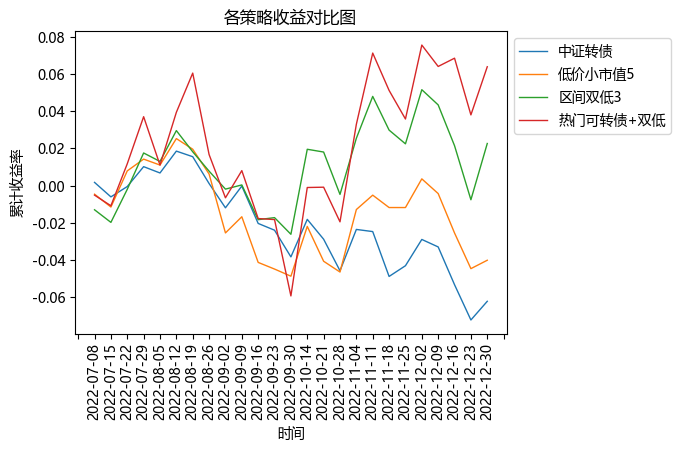

<Figure size 48000x18000 with 0 Axes>

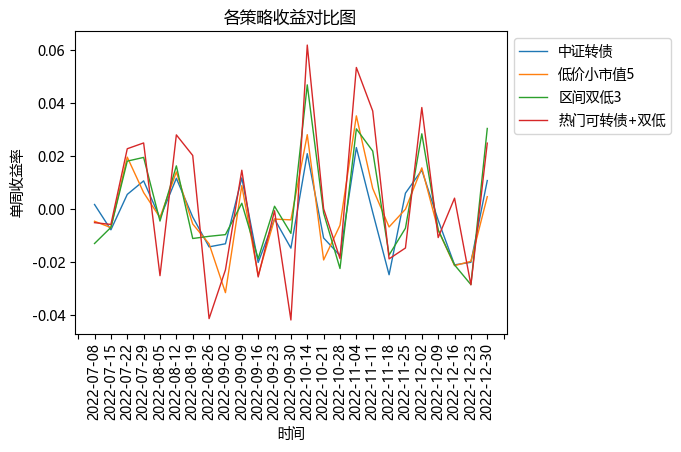

<Figure size 48000x18000 with 0 Axes>

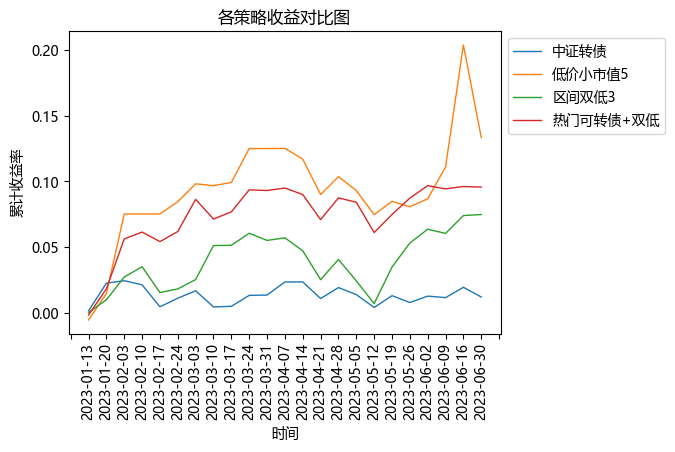

<Figure size 48000x18000 with 0 Axes>

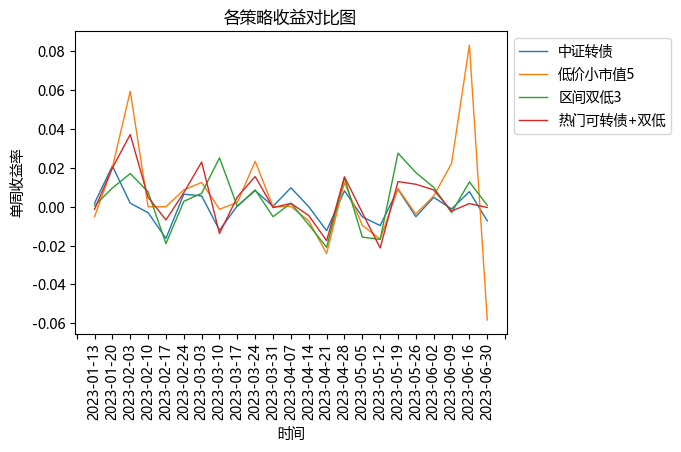

程序运行时间：20.58秒


In [60]:
# 跑1个回测周期,获得多个策略的单周收益率、累计收益率对比图
# 根据需要更改test_day_list回测周期，names策略
start_time = time.time()

test_day_list = [('2022-07-01','2022-12-31'), ('2023-01-01','2023-06-30')]

"""
需要哪些策略的收益对比图，就放进哪些，这样跑的速度快并且结果清晰
names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx', 
         '高ytm（全量数据DTBS，用于回测）.xlsx', 
         '区间双低3（全量数据DTBS，用于回测）.xlsx', 
         '双低5（全量数据DTBS，用于回测）.xlsx', 
         '小市值3双低5（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']
"""

names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx',
         '区间双低3（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']


set_which_day = 'mon'
          
for start_day,end_day in test_day_list:    
    profit_dict = {}   
    for name in names: 
        """
        my_position_df = pd.read_excel('pre_data_for_backtest\\'+ name)
        my_position_df = my_position_df.loc[(my_position_df['日期'] <= end_day) & (my_position_df['日期'] >= start_day)]

        # my_position = {}
        my_position_dates_list = sorted(set(list(my_position_df['日期'])))

        # trade_dates_list 设置调仓日期固定为每周几
        trade_dates_list = list(D_DF.loc[(D_DF['date'] >= start_day)&(D_DF['date'] <= end_day)&(D_DF['which_day'] == set_which_day), 'date'])

        my_position = {date : list(my_position_df.loc[my_position_df['日期'] == date,'可转债代码']) for date in  trade_dates_list}
        """        
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)

        # 获得收益率曲线列表    
        profit = get_period_profit(trade_dates_list, my_position, A_DF)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        strategy_name = str(name[ : name.index('（')])
        profit_dict[strategy_name] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
    display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略收益对比图', tick_spacing = 1)    

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------------------- 分页，便于阅读 ---------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------

In [61]:
# ----------------------------------------------------------------------------------------------------------------------
# --------------------------------------暂时用不着，以后也许有用，先留个备份，千万别删了 -------------------------------
# ----------------------------------------------------------------------------------------------------------------------

# 这是真正意义上的回测(这是原始版本未改动)，考虑了初始仓位和剩余的现金，考虑了止损与止盈，可以实现等权重换仓与等手数换仓

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# 解决中文乱码问题
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # 指定默认字体：解决plot不能显示中文问题
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
import bisect

# 设置初始资金1000万元
initial_money = 10000000

def get_current_total_money(current_date, current_money, current_postion_details, A_DF):
    
    """
    这个函数用于获取当前时刻账户内现金+转债价值之和,返回账户总市值
    current_date：现在的日期，
    current_money：代表账户内的现金数目,
    current_postion_details：传入持仓明细字典（Key是转债代码，Value是持有这只转债的数量，请传入合法转债代码与数量）
    A_DF：全量数据库中的A区，存放3点收盘价
    """
    
    if current_postion_details == {}:
        current_total_money = current_money
    else:
        # 获取当日转债价格字典
        current_day_A_DF = A_DF.loc[A_DF['date'] == current_date,['bond_code','dp']].copy()
        current_day_price_Dict = current_day_A_DF.set_index('bond_code')['dp'].to_dict()        
        current_total_money = current_money   
        
        for hold_bond_code,hold_num in current_postion_details.items():            
            # price = float(A_DF.loc[(A_DF['bond_code'] == hold_bond_code) & (A_DF['date'] == current_date),'dp'])
            price = current_day_price_Dict[hold_bond_code]
            bond_money = price * hold_num
            current_total_money = current_total_money + bond_money    
            
    return current_total_money

# 用于测试get_current_total_money的功能是否有效
print(get_current_total_money('2023-07-12',900000,{'110080.SH':1000,'123098.SZ':1000},A_DF))


def reposition(trade_dates_list, last_date, current_date, current_money, current_postion_details, A_DF, my_position, current_flag):
    
    """
    这个函数用于换仓，返回当前账户总市值、换仓后账户内现金、换仓后的持仓明细字典（Key是转债代码，Value是持有这只转债的数量）
    传入参数：
    current_date：现在的日期，
    current_money：当前账户内的现金数目,
    current_postion_details：当前持仓明细字典（Key是转债代码，Value是持有这只转债的数量，请传入合法转债代码与数量）
    A_DF：全量数据库中的A区，存放3点收盘价
    my_position：若每日换仓，则理论上的每日持仓的转债代码的字典（Key是日期，Value是转债代码的列表）
    flag：代表换仓模式，0代表等权重调仓，1代表等手数调仓
    """
    # 设置单日涨跌幅限制、总涨跌幅限制
    # 不设当日最大涨幅限制
    daily_price_up_limit = 100
    daily_price_down_limit = -0.02
    total_price_up_limit = 0.2
    total_price_down_limit = -0.05
    
    
    # 获取当前时刻账户内现金+转债价值之和
    current_total_money = get_current_total_money(current_date, current_money, current_postion_details, A_DF)
    
    # 获取当日转债价格字典
    current_day_A_DF = A_DF.loc[A_DF['date'] == current_date,['bond_code','dp']].copy()
    current_day_price_Dict = current_day_A_DF.set_index('bond_code')['dp'].to_dict()    
    
    if current_date in trade_dates_list:
        """当前日期是调仓日时，直接调仓"""
        print('\n',current_date,': 今日是调仓日')
        print('换仓前, 账户内剩余现金:',current_money,', 持仓明细字典:', current_postion_details)
        # 应该换入的转债代码列表
        trade_codes_list = my_position[current_date]
        
        if len(trade_codes_list) == 0:
            print('今日无适合买入的转债，空仓。')
            return current_total_money, current_total_money, {}
        else:
            
            if current_flag == 0:
                print('等权重调仓')
                # 等权重调仓，目前没有考虑交易成本

                # 每只转债的买入限额
                limit_money = current_total_money / len(trade_codes_list)

                # 获取换仓后的持仓明细字典
                after_postion_details = {trade_code:int(limit_money / current_day_price_Dict[trade_code]) for trade_code in trade_codes_list}

                # 获取换仓后的账户内现金金额
                # 直接调用get_current_total_money函数算出换仓后转债的总价值，用换仓前账户内现金+转债价值之和 - 换仓后转债的总价值即可得到换仓后账户现金
                # 钱必须是两位小数，后面的数字没有意义
                after_money = int((current_total_money - get_current_total_money(current_date, 0, after_postion_details, A_DF))*100)/100

            elif current_flag == 1:
                print('等份额调仓')
                # 等份额调仓，即每份转债买的数量相同
                price_list = list(current_day_A_DF.loc[current_day_A_DF.bond_code.isin(trade_codes_list),'dp'])
                price_sum = sum(price_list)
                # 买入份额
                i = int(current_total_money / price_sum)
                after_postion_details = {trade_code : i for trade_code in trade_codes_list}   
                after_money = int(((current_total_money - price_sum * i))*100)/100
                
            print('换仓后, 账户内剩余现金:',after_money,', 持仓明细字典:', after_postion_details)
            return current_total_money, after_money, after_postion_details
    else:
        """当前日期不是调仓日时，查看当前转债是否有需要止损或者止盈，若有则卖出，并重新调整仓位"""
        current_code_list = list(current_postion_details.keys())
        
        # 获得上一个交易日的价格字典
        last_day_A_DF = A_DF.loc[A_DF['date'] == last_date,['bond_code','dp']].copy()
        last_day_price_Dict = last_day_A_DF.set_index('bond_code')['dp'].to_dict()
        
        # 找到上一次换仓日，获得上一个换仓日的价格字典
        last_trade_date = trade_dates_list[bisect.bisect_right(trade_dates_list, current_date)-1]
        last_trade_day_A_DF = A_DF.loc[A_DF['date'] == last_trade_date,['bond_code','dp']].copy()
        last_trade_day_price_Dict = last_trade_day_A_DF.set_index('bond_code')['dp'].to_dict()
        
        
        after_code_list = []
        
        print('\n', current_date,': 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。')
        print('换仓前, 账户内剩余现金:',current_money,', 持仓明细字典:', current_postion_details)
        
        if len(current_code_list) == 0:
            print('空仓，无需监控。')
            return current_total_money, current_total_money, {}
        else:
            for current_code in current_code_list:
                if current_day_price_Dict[current_code] / last_day_price_Dict[current_code] - 1 > daily_price_up_limit:
                    print(current_code,'：突破当日最大涨幅限制，需要止盈。')
                elif current_day_price_Dict[current_code] / last_day_price_Dict[current_code] - 1 < daily_price_down_limit:
                    print(current_code,'：突破当日最大跌幅限制，需要止损。')
                elif current_day_price_Dict[current_code] / last_trade_day_price_Dict[current_code] -1 > total_price_up_limit:
                    print(current_code,'：突破最大涨幅限制，需要止盈。')
                elif current_day_price_Dict[current_code] / last_trade_day_price_Dict[current_code] -1 < total_price_down_limit:
                    print(current_code,'：突破最大跌幅限制，需要止损。')
                else:
                    after_code_list.append(current_code)
                    
            if len(after_code_list) < len(current_code_list):
                print('有转债止损/止盈，当日需要重新调仓！')
                
                if len(after_code_list) == 0:
                    print('今日调仓后所有转债均已卖出，空仓。')
                    return current_total_money, current_total_money, {}
                
                else:
                    if current_flag == 0:
                        print('等权重调仓')
                        # 等权重调仓，目前没有考虑交易成本

                        # 每只转债的买入限额
                        limit_money = current_total_money / len(after_code_list)

                        # 获取换仓后的持仓明细字典
                        after_postion_details = {trade_code:int(limit_money / current_day_price_Dict[after_code]) for after_code in after_code_list}

                        # 获取换仓后的账户内现金金额
                        # 直接调用get_current_total_money函数算出换仓后转债的总价值，用换仓前账户内现金+转债价值之和 - 换仓后转债的总价值即可得到换仓后账户现金
                        # 钱必须是两位小数，后面的数字没有意义
                        after_money = int((current_total_money - get_current_total_money(current_date, 0, after_postion_details, A_DF))*100)/100

                    elif current_flag == 1:
                        # 等份额调仓，即每份转债买的数量相同
                        print('等份额调仓')
                        price_list = list(current_day_A_DF.loc[current_day_A_DF.bond_code.isin(after_code_list),'dp'])
                        price_sum = sum(price_list)
                        # 买入份额
                        i = int(current_total_money / price_sum)
                        after_postion_details = {after_code : i for after_code in after_code_list}   
                        after_money = int(((current_total_money - price_sum * i))*100)/100

                    print('换仓后, 账户内剩余现金:',after_money,', 持仓明细字典:', after_postion_details)
                    return current_total_money, after_money, after_postion_details
                
            else:
                print('没有转债需要止损/止盈，当日无需重新调仓！')
                return current_total_money, current_money, current_postion_details
                
# 用于测试reposition的功能是否有效
# reposition('2023-07-12', 900000, {'110080.SH':1000,'123098.SZ':1000}, A_DF, my_position, 0)

def get_weekly_return(trade_dates_list,D_DF,A_DF,initial_money,my_position,my_current_flag):
    # 返回单周收益率列表  
    start_day = trade_dates_list[0]
    end_day = trade_dates_list[-1]
    
    test_dates_list = sorted(list(D_DF.loc[(D_DF['date'] >= start_day) & (D_DF['date'] <= end_day),'date']))
    
    total_money_list = []
    
    # 第一次换仓
    current_total_money, after_money, after_postion_details = reposition(trade_dates_list, '', test_dates_list[0], initial_money, {}, A_DF, my_position, current_flag=my_current_flag)
    total_money_list.append(current_total_money)
    
    # 后续换仓
    for test_day_index in range(1,len(test_dates_list)):
        current_date = test_dates_list[test_day_index]
        last_date = test_dates_list[test_day_index-1]
        current_total_money, after_money, after_postion_details = reposition(trade_dates_list, last_date, current_date, after_money, after_postion_details, A_DF, my_position, current_flag=my_current_flag)
        if current_date in trade_dates_list:
            total_money_list.append(current_total_money)
    
    profit = [total_money_list[index] / total_money_list[index-1] - 1 for index in range(1, len(total_money_list))]
    # print(total_money_list,profit)
    
    return profit


1196433.0



 2021-04-26 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}

 2021-04-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
113576.SH ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调


 2021-06-28 : 今日是调仓日
换仓前, 账户内剩余现金: 395.96 , 持仓明细字典: {'123011.SZ': 19761, '113601.SH': 19761, '113566.SH': 19761, '113624.SH': 19761, '123080.SZ': 19761}
等份额调仓
换仓后, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 20362, '128069.SZ': 20362, '123080.SZ': 20362}

 2021-06-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 20362, '128069.SZ': 20362, '123080.SZ': 20362}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 20362, '128069.SZ': 20362, '123080.SZ': 20362}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-07-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 20362, '128069.SZ': 20362, '123080.SZ': 20362}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-07-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 20


 2021-08-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 228.7 , 持仓明细字典: {'123028.SZ': 21056, '128117.SZ': 21056, '113600.SH': 21056, '113578.SH': 21056, '113624.SH': 21056}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-23 : 今日是调仓日
换仓前, 账户内剩余现金: 228.7 , 持仓明细字典: {'123028.SZ': 21056, '128117.SZ': 21056, '113600.SH': 21056, '113578.SH': 21056, '113624.SH': 21056}
等份额调仓
换仓后, 账户内剩余现金: 113.26 , 持仓明细字典: {'123028.SZ': 21063, '113591.SH': 21063, '128074.SZ': 21063, '113578.SH': 21063, '113624.SH': 21063}

 2021-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 113.26 , 持仓明细字典: {'123028.SZ': 21063, '113591.SH': 21063, '128074.SZ': 21063, '113578.SH': 21063, '113624.SH': 21063}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 113.26 , 持仓明细字典: {'123028.SZ': 21063, '113591.SH': 21063, '128074.SZ': 21063, '113578.SH': 21063, '113624.SH': 21063}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 113.26 , 持仓明细字典: {'123028.SZ': 21063, '113591.SH': 21063, '128074.SZ':


 2021-10-25 : 今日是调仓日
换仓前, 账户内剩余现金: 39.07 , 持仓明细字典: {'128066.SZ': 22808, '123106.SZ': 22808, '128070.SZ': 22808, '123082.SZ': 22808, '113546.SH': 22808}
等份额调仓
换仓后, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 23425, '128074.SZ': 23425, '113628.SH': 23425}

 2021-10-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 23425, '128074.SZ': 23425, '113628.SH': 23425}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 23425, '128074.SZ': 23425, '113628.SH': 23425}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 23425, '128074.SZ': 23425, '113628.SH': 23425}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 234


 2021-12-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 282.78 , 持仓明细字典: {'113589.SH': 25210, '113519.SH': 25210, '113601.SH': 25210, '128069.SZ': 25210, '113597.SH': 25210}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 282.78 , 持仓明细字典: {'113589.SH': 25210, '113519.SH': 25210, '113601.SH': 25210, '128069.SZ': 25210, '113597.SH': 25210}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-20 : 今日是调仓日
换仓前, 账户内剩余现金: 282.78 , 持仓明细字典: {'113589.SH': 25210, '113519.SH': 25210, '113601.SH': 25210, '128069.SZ': 25210, '113597.SH': 25210}
等份额调仓
换仓后, 账户内剩余现金: 28.62 , 持仓明细字典: {'113519.SH': 25209, '123056.SZ': 25209, '128117.SZ': 25209, '113573.SH': 25209, '128118.SZ': 25209}

 2021-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 28.62 , 持仓明细字典: {'113519.SH': 25209, '123056.SZ': 25209, '128117.SZ': 25209, '113573.SH': 25209, '128118.SZ': 25209}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 28.62 , 持仓明细字典: {'113519.SH': 25209, '123056.SZ': 25209, '128117.SZ': 


 2022-02-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 115.46 , 持仓明细字典: {'128138.SZ': 63395, '128118.SZ': 63395}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-21 : 今日是调仓日
换仓前, 账户内剩余现金: 115.46 , 持仓明细字典: {'128138.SZ': 63395, '128118.SZ': 63395}
等份额调仓
换仓后, 账户内剩余现金: 215.96 , 持仓明细字典: {'113595.SH': 26071, '113569.SH': 26071, '123044.SZ': 26071, '123093.SZ': 26071, '113573.SH': 26071}

 2022-02-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 215.96 , 持仓明细字典: {'113595.SH': 26071, '113569.SH': 26071, '123044.SZ': 26071, '123093.SZ': 26071, '113573.SH': 26071}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 215.96 , 持仓明细字典: {'113595.SH': 26071, '113569.SH': 26071, '123044.SZ': 26071, '123093.SZ': 26071, '113573.SH': 26071}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 215.96 , 持仓明细字典: {'113595.SH': 26071, '113569.SH': 26071, '123044.SZ': 26071, '123093.SZ': 26071, '113573.SH': 26071}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户


 2022-04-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 447.03 , 持仓明细字典: {'113576.SH': 25490, '113573.SH': 25490, '128074.SZ': 25490, '123093.SZ': 25490, '113628.SH': 25490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-18 : 今日是调仓日
换仓前, 账户内剩余现金: 447.03 , 持仓明细字典: {'113576.SH': 25490, '113573.SH': 25490, '128074.SZ': 25490, '123093.SZ': 25490, '113628.SH': 25490}
等份额调仓
换仓后, 账户内剩余现金: 193.1 , 持仓明细字典: {'113569.SH': 26119, '128074.SZ': 26119, '113578.SH': 26119, '113628.SH': 26119, '113584.SH': 26119}
单周收益率： [0.013286592999999902, 0.009117077600571788, 0.014621602155352242, 0.0024153954292827073, -0.0042402012695628155, -0.011272451637954095, 0.03233289516268978, -0.008666820247779095, 0.024568511728154885, 0.005496087551219109, -0.0095060734831649, 0.013942117720872504, 0.008855727096983568, 0.01476641787926547, 0.0017453633897064336, 0.02492467052601799, 0.021765868048663872, 0.12558889171517174, -0.03511132036890163, 0.014479635793389845, -0.008194899280721035, 0.0023662242198601025, 0.01184514413282245

<Figure size 36000x18000 with 0 Axes>

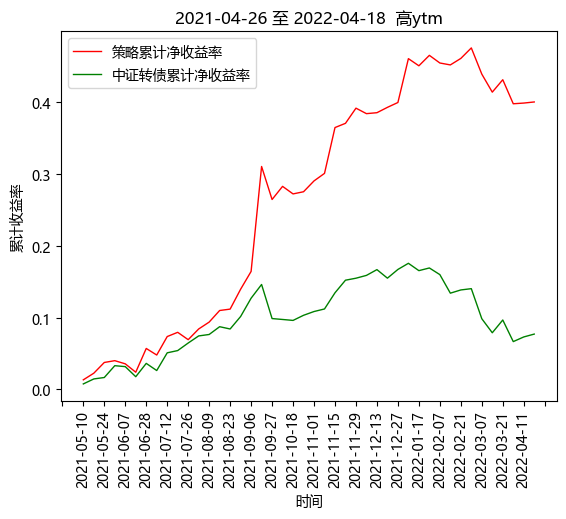

<Figure size 36000x18000 with 0 Axes>

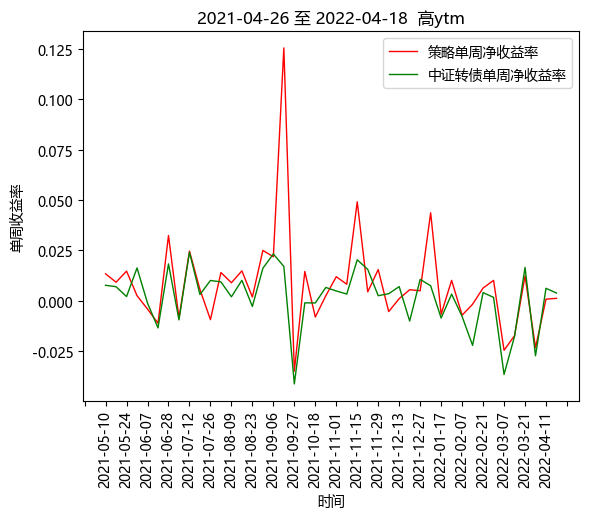

周期： 2021-04-26 至 2022-04-18
策略累计收益率： 0.40046785200000046
中证转债累计收益率： 0.07703222005062527
胜率1（收益率大于0的比例）： 0.7045454545454546
胜率2（收益率高于中证转债指数的比例）： 0.7045454545454546
夏普比率： 2.2340466159494343
最大回撤： 0.052729186083345196
年化波动率： 0.16442152514240702
收益率最好的一周： 2021-09-06 至 2021-09-13
最高单周收益率 0.12558889171517174
收益率最差的一周： 2021-09-13 至 2021-09-27
最低单周收益率 -0.03511132036890163
程序运行时间：20.38秒


In [18]:
# 回测单个策略（这样速度更快），考虑了初始仓位和剩余的现金，考虑了止损与止盈，可以实现等权重换仓与等手数换仓
names_and_which_day = [('高ytm（全量数据DTBS，用于回测）.xlsx', 'mon')]
test_day_list = [('2021-04-20','2022-04-19')]

start_time = time.time()

for start_day,end_day in test_day_list: 
    for name,which_day in names_and_which_day: 
        """两层循环是为了实现一次性回测多个策略与多个周期"""
        
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)
        
        # -------------------------------------------------------------------------------------------------------------------------------------------
        # 直接调用已经定义好的3个函数，传入理论的持仓字典my_position（Key是日期，Value是转债代码的列表）、trade_dates_list（交易日期的列表）
        # -------------------------------------------------------------------------------------------------------------------------------------------

        # 获得收益率曲线列表    
        profit = get_weekly_return(trade_dates_list,D_DF,A_DF,10000000,my_position,my_current_flag=1)

        # 调用画图函数，更改tick_spacing的值可以调整打印密度
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = display(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 2)
        
        # 计算各类指标
        calculate_indicators(trade_dates_list, weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return)

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")


 2022-07-04 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 140.03 , 持仓明细字典: {'110070.SH': 39648, '128143.SZ': 39648}

 2022-07-05 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 140.03 , 持仓明细字典: {'110070.SH': 39648, '128143.SZ': 39648}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-06 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 140.03 , 持仓明细字典: {'110070.SH': 39648, '128143.SZ': 39648}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-07 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 140.03 , 持仓明细字典: {'110070.SH': 39648, '128143.SZ': 39648}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-08 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 140.03 , 持仓明细字典: {'110070.SH': 39648, '128143.SZ': 39648}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-11 : 今日是调仓日
换仓前, 账户内剩余现金: 140.03 , 持仓明细字典: {'110070.SH': 39648, '128143.SZ': 39648}
等份额调仓
换仓后, 账户内剩余现金: 537.09 , 持仓明细字典: {'113030.SH': 16014, '123080.SZ': 16014, '123002.SZ': 16014, '113565.SH': 16014, '113577.SH': 16014}

 2022-07-12 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 537.09 , 持仓明细字典: {'113030.SH': 16014,


 2022-09-09 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 210.43 , 持仓明细字典: {'113030.SH': 17497, '110070.SH': 17497, '128076.SZ': 17497, '128071.SZ': 17497, '113565.SH': 17497}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 210.43 , 持仓明细字典: {'113030.SH': 17497, '110070.SH': 17497, '128076.SZ': 17497, '128071.SZ': 17497, '113565.SH': 17497}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 210.43 , 持仓明细字典: {'113030.SH': 17497, '110070.SH': 17497, '128076.SZ': 17497, '128071.SZ': 17497, '113565.SH': 17497}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 210.43 , 持仓明细字典: {'113030.SH': 17497, '110070.SH': 17497, '128076.SZ': 17497, '128071.SZ': 17497, '113565.SH': 17497}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 210.43 , 持仓明细字典: {'113030.SH': 17497, '110070.SH': 17497, '128076.SZ': 17497, '128071.SZ': 17497, '113565.SH': 17497}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-19 : 今日是调仓日
换仓前


 2022-11-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 133.97 , 持仓明细字典: {'123139.SZ': 17557, '113561.SH': 17557, '113570.SH': 17557, '128143.SZ': 17557, '111003.SH': 17557}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 133.97 , 持仓明细字典: {'123139.SZ': 17557, '113561.SH': 17557, '113570.SH': 17557, '128143.SZ': 17557, '111003.SH': 17557}
123139.SZ ：突破当日最大跌幅限制，需要止损。
128143.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 226.45 , 持仓明细字典: {'113561.SH': 28850, '113570.SH': 28850, '111003.SH': 28850}

 2022-11-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 226.45 , 持仓明细字典: {'113561.SH': 28850, '113570.SH': 28850, '111003.SH': 28850}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-21 : 今日是调仓日
换仓前, 账户内剩余现金: 226.45 , 持仓明细字典: {'113561.SH': 28850, '113570.SH': 28850, '111003.SH': 28850}
等份额调仓
换仓后, 账户内剩余现金: 142.62 , 持仓明细字典: {'123061.SZ': 18014, '111003.SH': 18014, '118007.SH': 18014, '113526.SH': 18014, '110070.SH': 18014}

 2022-11-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现


 2022-07-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 709.59 , 持仓明细字典: {'128066.SZ': 13571, '128085.SZ': 13571, '123129.SZ': 13571, '123063.SZ': 13571, '123080.SZ': 13571, '123100.SZ': 13571}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-18 : 今日是调仓日
换仓前, 账户内剩余现金: 709.59 , 持仓明细字典: {'128066.SZ': 13571, '128085.SZ': 13571, '123129.SZ': 13571, '123063.SZ': 13571, '123080.SZ': 13571, '123100.SZ': 13571}
等份额调仓
换仓后, 账户内剩余现金: 664.12 , 持仓明细字典: {'128066.SZ': 13805, '128049.SZ': 13805, '113601.SH': 13805, '123063.SZ': 13805, '123080.SZ': 13805, '123044.SZ': 13805}

 2022-07-19 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 664.12 , 持仓明细字典: {'128066.SZ': 13805, '128049.SZ': 13805, '113601.SH': 13805, '123063.SZ': 13805, '123080.SZ': 13805, '123044.SZ': 13805}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 664.12 , 持仓明细字典: {'128066.SZ': 13805, '128049.SZ': 13805, '113601.SH': 13805, '123063.SZ': 13805, '123080.SZ': 13805, '123044.SZ': 13805}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-07-21 : 今日是非调仓日，


 2022-08-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 654.67 , 持仓明细字典: {'123129.SZ': 14705, '127054.SZ': 14705, '113588.SH': 14705, '113649.SH': 14705, '123044.SZ': 14705, '123087.SZ': 14705}
123087.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 435.34 , 持仓明细字典: {'123129.SZ': 17702, '127054.SZ': 17702, '113588.SH': 17702, '113649.SH': 17702, '123044.SZ': 17702}

 2022-09-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 435.34 , 持仓明细字典: {'123129.SZ': 17702, '127054.SZ': 17702, '113588.SH': 17702, '113649.SH': 17702, '123044.SZ': 17702}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 435.34 , 持仓明细字典: {'123129.SZ': 17702, '127054.SZ': 17702, '113588.SH': 17702, '113649.SH': 17702, '123044.SZ': 17702}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-09-05 : 今日是调仓日
换仓前, 账户内剩余现金: 435.34 , 持仓明细字典: {'123129.SZ': 17702, '127054.SZ': 17702, '113588.SH': 17702, '113649.SH': 17702, '123044.SZ': 17702}
等份额调仓
换仓后, 账户内剩余现金: 125.71 , 持仓明细字典: {'128071.SZ': 14633, '128097.SZ': 14633, 


 2022-10-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 540.55 , 持仓明细字典: {'128066.SZ': 18055, '113595.SH': 18055, '128085.SZ': 18055, '123130.SZ': 18055, '123044.SZ': 18055}
113595.SH ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 189.31 , 持仓明细字典: {'128066.SZ': 22170, '128085.SZ': 22170, '123130.SZ': 22170, '123044.SZ': 22170}

 2022-10-31 : 今日是调仓日
换仓前, 账户内剩余现金: 189.31 , 持仓明细字典: {'128066.SZ': 22170, '128085.SZ': 22170, '123130.SZ': 22170, '123044.SZ': 22170}
等份额调仓
换仓后, 账户内剩余现金: 68.04 , 持仓明细字典: {'128066.SZ': 14359, '128075.SZ': 14359, '123063.SZ': 14359, '113649.SH': 14359, '123147.SZ': 14359, '123156.SZ': 14359}

 2022-11-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 68.04 , 持仓明细字典: {'128066.SZ': 14359, '128075.SZ': 14359, '123063.SZ': 14359, '113649.SH': 14359, '123147.SZ': 14359, '123156.SZ': 14359}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 68.04 , 持仓明细字典: {'128066.SZ': 14359, '128075.SZ': 14359, '123063.SZ': 14359, '113649.SH': 14359, '1231


 2022-12-19 : 今日是调仓日
换仓前, 账户内剩余现金: 333.44 , 持仓明细字典: {'113595.SH': 15177, '128085.SZ': 15177, '118016.SH': 15177, '113591.SH': 15177, '123141.SZ': 15177, '123144.SZ': 15177}
等份额调仓
换仓后, 账户内剩余现金: 320.43 , 持仓明细字典: {'113595.SH': 14667, '123063.SZ': 14667, '113591.SH': 14667, '111004.SH': 14667, '123089.SZ': 14667, '123162.SZ': 14667}

 2022-12-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 320.43 , 持仓明细字典: {'113595.SH': 14667, '123063.SZ': 14667, '113591.SH': 14667, '111004.SH': 14667, '123089.SZ': 14667, '123162.SZ': 14667}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 320.43 , 持仓明细字典: {'113595.SH': 14667, '123063.SZ': 14667, '113591.SH': 14667, '111004.SH': 14667, '123089.SZ': 14667, '123162.SZ': 14667}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 320.43 , 持仓明细字典: {'113595.SH': 14667, '123063.SZ': 14667, '113591.SH': 14667, '111004.SH': 14667, '123089.SZ': 14667, '123162.SZ': 14667}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-23 : 今日是非调仓日，


 2022-08-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 428.05 , 持仓明细字典: {'113546.SH': 16223, '127060.SZ': 16223, '128014.SZ': 16223, '128037.SZ': 16223, '128075.SZ': 16223}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 428.05 , 持仓明细字典: {'113546.SH': 16223, '127060.SZ': 16223, '128014.SZ': 16223, '128037.SZ': 16223, '128075.SZ': 16223}
113546.SH ：突破当日最大跌幅限制，需要止损。
128014.SZ ：突破当日最大跌幅限制，需要止损。
128075.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 114.31 , 持仓明细字典: {'127060.SZ': 41094, '128037.SZ': 41094}

 2022-08-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 114.31 , 持仓明细字典: {'127060.SZ': 41094, '128037.SZ': 41094}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 114.31 , 持仓明细字典: {'127060.SZ': 41094, '128037.SZ': 41094}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-29 : 今日是调仓日
换仓前, 账户内剩余现金: 114.31 , 持仓明细字典: {'127060.SZ': 41094, '128037.SZ': 41094}
等份额调仓
换仓后, 账户内剩余现金: 238.36 , 持仓明细字典: {'113519.SH': 7970, '113591.SH': 7970, '113600.SH'


 2022-10-10 : 今日是调仓日
换仓前, 账户内剩余现金: 158.63 , 持仓明细字典: {'113030.SH': 15771, '113519.SH': 15771, '128042.SZ': 15771, '128087.SZ': 15771, '128121.SZ': 15771}
等份额调仓
换仓后, 账户内剩余现金: 733.16 , 持仓明细字典: {'110074.SH': 7693, '113030.SH': 7693, '113039.SH': 7693, '113598.SH': 7693, '113649.SH': 7693, '127028.SZ': 7693, '128037.SZ': 7693, '128042.SZ': 7693, '128097.SZ': 7693, '128121.SZ': 7693}

 2022-10-11 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 733.16 , 持仓明细字典: {'110074.SH': 7693, '113030.SH': 7693, '113039.SH': 7693, '113598.SH': 7693, '113649.SH': 7693, '127028.SZ': 7693, '128037.SZ': 7693, '128042.SZ': 7693, '128097.SZ': 7693, '128121.SZ': 7693}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-12 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 733.16 , 持仓明细字典: {'110074.SH': 7693, '113030.SH': 7693, '113039.SH': 7693, '113598.SH': 7693, '113649.SH': 7693, '127028.SZ': 7693, '128037.SZ': 7693, '128042.SZ': 7693, '128097.SZ': 7693, '128121.SZ': 7693}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户


 2022-11-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 161.36 , 持仓明细字典: {'111004.SH': 13138, '113649.SH': 13138, '123157.SZ': 13138, '127014.SZ': 13138, '128066.SZ': 13138, '128090.SZ': 13138}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 161.36 , 持仓明细字典: {'111004.SH': 13138, '113649.SH': 13138, '123157.SZ': 13138, '127014.SZ': 13138, '128066.SZ': 13138, '128090.SZ': 13138}
113649.SH ：突破最大涨幅限制，需要止盈。
127014.SZ ：突破当日最大跌幅限制，需要止损。
128090.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 24.73 , 持仓明细字典: {'111004.SH': 27813, '123157.SZ': 27813, '128066.SZ': 27813}

 2022-11-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 24.73 , 持仓明细字典: {'111004.SH': 27813, '123157.SZ': 27813, '128066.SZ': 27813}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-11-21 : 今日是调仓日
换仓前, 账户内剩余现金: 24.73 , 持仓明细字典: {'111004.SH': 27813, '123157.SZ': 27813, '128066.SZ': 27813}
等份额调仓
换仓后, 账户内剩余现金: 10.2 , 持仓明细字典: {'113570.SH': 13447, '118021.SH': 13447, '123156.SZ': 13447, '123157.SZ': 13447, '127028.SZ'

<Figure size 48000x18000 with 0 Axes>

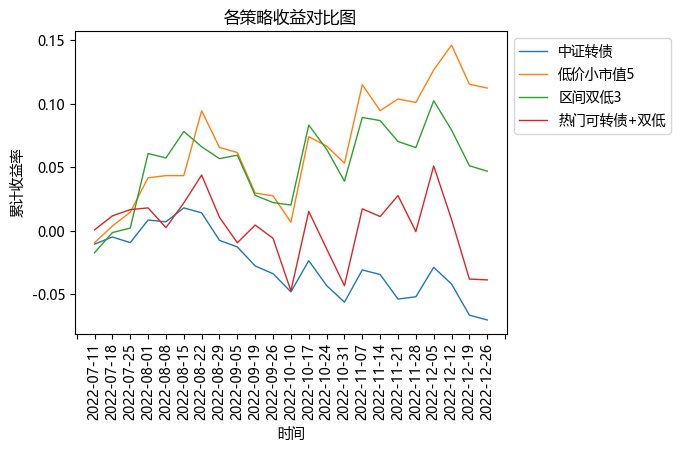

<Figure size 48000x18000 with 0 Axes>

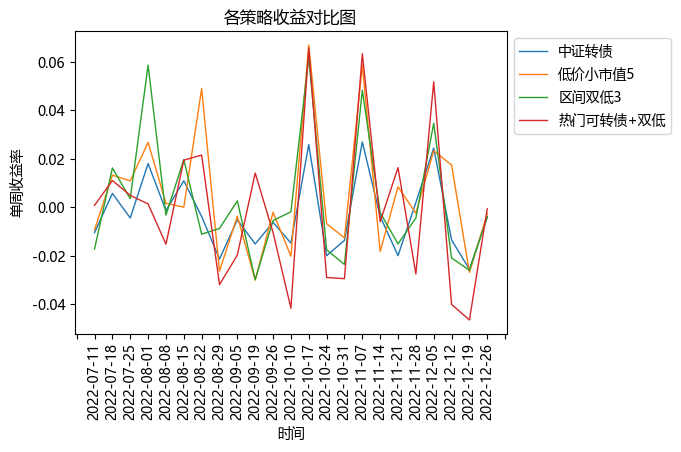


 2023-01-09 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 21.31 , 持仓明细字典: {'113565.SH': 16691, '110070.SH': 16691, '113030.SH': 16691, '113577.SH': 16691, '128021.SZ': 16691}

 2023-01-10 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 21.31 , 持仓明细字典: {'113565.SH': 16691, '110070.SH': 16691, '113030.SH': 16691, '113577.SH': 16691, '128021.SZ': 16691}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-11 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 21.31 , 持仓明细字典: {'113565.SH': 16691, '110070.SH': 16691, '113030.SH': 16691, '113577.SH': 16691, '128021.SZ': 16691}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-12 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 21.31 , 持仓明细字典: {'113565.SH': 16691, '110070.SH': 16691, '113030.SH': 16691, '113577.SH': 16691, '128021.SZ': 16691}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 21.31 , 持仓明细字典: {'113565.SH': 16691, '110070.SH': 16691, '113030.SH': 16691, '113577.SH': 16691, '128021.SZ': 16691}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-01-16 : 今日是调仓日
换仓前, 账户


 2023-03-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 433.77 , 持仓明细字典: {'123103.SZ': 21945, '113565.SH': 21945, '113527.SH': 21945, '113566.SH': 21945}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 433.77 , 持仓明细字典: {'123103.SZ': 21945, '113565.SH': 21945, '113527.SH': 21945, '113566.SH': 21945}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 433.77 , 持仓明细字典: {'123103.SZ': 21945, '113565.SH': 21945, '113527.SH': 21945, '113566.SH': 21945}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-03 : 今日是调仓日
换仓前, 账户内剩余现金: 433.77 , 持仓明细字典: {'123103.SZ': 21945, '113565.SH': 21945, '113527.SH': 21945, '113566.SH': 21945}
等份额调仓
换仓后, 账户内剩余现金: 467.74 , 持仓明细字典: {'128033.SZ': 17536, '110070.SH': 17536, '128039.SZ': 17536, '123103.SZ': 17536, '113577.SH': 17536}

 2023-04-04 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 467.74 , 持仓明细字典: {'128033.SZ': 17536, '110070.SH': 17536, '128039.SZ': 17536, '123103.SZ': 17536, '113577.SH': 17536}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-0


 2023-05-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 167.91 , 持仓明细字典: {'113566.SH': 17499, '128039.SZ': 17499, '113526.SH': 17499, '110070.SH': 17499, '128053.SZ': 17499}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-05-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 167.91 , 持仓明细字典: {'113566.SH': 17499, '128039.SZ': 17499, '113526.SH': 17499, '110070.SH': 17499, '128053.SZ': 17499}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 167.91 , 持仓明细字典: {'113566.SH': 17499, '128039.SZ': 17499, '113526.SH': 17499, '110070.SH': 17499, '128053.SZ': 17499}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 167.91 , 持仓明细字典: {'113566.SH': 17499, '128039.SZ': 17499, '113526.SH': 17499, '110070.SH': 17499, '128053.SZ': 17499}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-05 : 今日是调仓日
换仓前, 账户内剩余现金: 167.91 , 持仓明细字典: {'113566.SH': 17499, '128039.SZ': 17499, '113526.SH': 17499, '110070.SH': 17499, '128053.SZ': 17499}
等份额调仓
换仓后, 账户内剩余现金: 183.45 , 持仓明细字典: {'128021.SZ': 22129, '113526.


 2023-02-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 523.43 , 持仓明细字典: {'113595.SH': 15024, '128066.SZ': 15024, '113532.SH': 15024, '123063.SZ': 15024, '127055.SZ': 15024, '113665.SH': 15024}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 523.43 , 持仓明细字典: {'113595.SH': 15024, '128066.SZ': 15024, '113532.SH': 15024, '123063.SZ': 15024, '127055.SZ': 15024, '113665.SH': 15024}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 523.43 , 持仓明细字典: {'113595.SH': 15024, '128066.SZ': 15024, '113532.SH': 15024, '123063.SZ': 15024, '127055.SZ': 15024, '113665.SH': 15024}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 523.43 , 持仓明细字典: {'113595.SH': 15024, '128066.SZ': 15024, '113532.SH': 15024, '123063.SZ': 15024, '127055.SZ': 15024, '113665.SH': 15024}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-20 : 今日是调仓日
换仓前, 账户内剩余现金: 523.43 , 持仓明细字典: {'113595.SH': 15024, '128066.SZ': 15024, '113532.SH': 15024, '123063.SZ': 15024, '12705


 2023-04-06 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 336.06 , 持仓明细字典: {'118016.SH': 14604, '113628.SH': 14604, '113532.SH': 14604, '123141.SZ': 14604, '123162.SZ': 14604, '127059.SZ': 14604}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-07 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 336.06 , 持仓明细字典: {'118016.SH': 14604, '113628.SH': 14604, '113532.SH': 14604, '123141.SZ': 14604, '123162.SZ': 14604, '127059.SZ': 14604}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-10 : 今日是调仓日
换仓前, 账户内剩余现金: 336.06 , 持仓明细字典: {'118016.SH': 14604, '113628.SH': 14604, '113532.SH': 14604, '123141.SZ': 14604, '123162.SZ': 14604, '127059.SZ': 14604}
等份额调仓
换仓后, 账户内剩余现金: 438.52 , 持仓明细字典: {'118016.SH': 14554, '127059.SZ': 14554, '113628.SH': 14554, '123141.SZ': 14554, '123175.SZ': 14554, '123153.SZ': 14554}

 2023-04-11 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 438.52 , 持仓明细字典: {'118016.SH': 14554, '127059.SZ': 14554, '113628.SH': 14554, '123141.SZ': 14554, '123175.SZ': 14554, '123153.SZ': 14554}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-04-12 : 今日是非调仓日，


 2023-05-29 : 今日是调仓日
换仓前, 账户内剩余现金: 437.65 , 持仓明细字典: {'118016.SH': 14326, '123160.SZ': 14326, '113628.SH': 14326, '123141.SZ': 14326, '123063.SZ': 14326, '113649.SH': 14326}
等份额调仓
换仓后, 账户内剩余现金: 353.05 , 持仓明细字典: {'118016.SH': 14439, '123160.SZ': 14439, '113651.SH': 14439, '123063.SZ': 14439, '113628.SH': 14439, '123141.SZ': 14439}

 2023-05-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 353.05 , 持仓明细字典: {'118016.SH': 14439, '123160.SZ': 14439, '113651.SH': 14439, '123063.SZ': 14439, '113628.SH': 14439, '123141.SZ': 14439}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-05-31 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 353.05 , 持仓明细字典: {'118016.SH': 14439, '123160.SZ': 14439, '113651.SH': 14439, '123063.SZ': 14439, '113628.SH': 14439, '123141.SZ': 14439}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-01 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 353.05 , 持仓明细字典: {'118016.SH': 14439, '123160.SZ': 14439, '113651.SH': 14439, '123063.SZ': 14439, '113628.SH': 14439, '123141.SZ': 14439}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-02 : 今日是非调仓日，


 2023-02-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 13.16 , 持仓明细字典: {'127028.SZ': 13628, '127054.SZ': 13628, '127055.SZ': 13628, '128044.SZ': 13628, '128087.SZ': 13628, '128090.SZ': 13628}
128044.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 594.58 , 持仓明细字典: {'127028.SZ': 16203, '127054.SZ': 16203, '127055.SZ': 16203, '128087.SZ': 16203, '128090.SZ': 16203}

 2023-02-03 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 594.58 , 持仓明细字典: {'127028.SZ': 16203, '127054.SZ': 16203, '127055.SZ': 16203, '128087.SZ': 16203, '128090.SZ': 16203}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-06 : 今日是调仓日
换仓前, 账户内剩余现金: 594.58 , 持仓明细字典: {'127028.SZ': 16203, '127054.SZ': 16203, '127055.SZ': 16203, '128087.SZ': 16203, '128090.SZ': 16203}
等份额调仓
换仓后, 账户内剩余现金: 525.45 , 持仓明细字典: {'113570.SH': 11436, '123075.SZ': 11436, '127028.SZ': 11436, '127054.SZ': 11436, '128044.SZ': 11436, '128049.SZ': 11436, '128087.SZ': 11436}

 2023-02-07 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 525.45 , 持仓明细字典: {'113570.SH': 11436, '12


 2023-03-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 279.03 , 持仓明细字典: {'110070.SH': 8870, '113588.SH': 8870, '123130.SZ': 8870, '123147.SZ': 8870, '123168.SZ': 8870, '127035.SZ': 8870, '128033.SZ': 8870, '128075.SZ': 8870, '128087.SZ': 8870}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 279.03 , 持仓明细字典: {'110070.SH': 8870, '113588.SH': 8870, '123130.SZ': 8870, '123147.SZ': 8870, '123168.SZ': 8870, '127035.SZ': 8870, '128033.SZ': 8870, '128075.SZ': 8870, '128087.SZ': 8870}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-16 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 279.03 , 持仓明细字典: {'110070.SH': 8870, '113588.SH': 8870, '123130.SZ': 8870, '123147.SZ': 8870, '123168.SZ': 8870, '127035.SZ': 8870, '128033.SZ': 8870, '128075.SZ': 8870, '128087.SZ': 8870}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-03-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 279.03 , 持仓明细字典: {'110070.SH': 8870, '113588.SH': 8870, '123130.SZ': 8870, '123147.SZ': 8870, '123168.SZ': 8870, '127035.SZ': 8870, '128033.SZ': 88


 2023-04-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 502.99 , 持仓明细字典: {'111005.SH': 6387, '113651.SH': 6387, '118021.SH': 6387, '123050.SZ': 6387, '123063.SZ': 6387, '123112.SZ': 6387, '123127.SZ': 6387, '123130.SZ': 6387, '123156.SZ': 6387, '123175.SZ': 6387, '128017.SZ': 6387, '128026.SZ': 6387, '128049.SZ': 6387}
128017.SZ ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 195.87 , 持仓明细字典: {'111005.SH': 6952, '113651.SH': 6952, '118021.SH': 6952, '123050.SZ': 6952, '123063.SZ': 6952, '123112.SZ': 6952, '123127.SZ': 6952, '123130.SZ': 6952, '123156.SZ': 6952, '123175.SZ': 6952, '128026.SZ': 6952, '128049.SZ': 6952}

 2023-04-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 195.87 , 持仓明细字典: {'111005.SH': 6952, '113651.SH': 6952, '118021.SH': 6952, '123050.SZ': 6952, '123063.SZ': 6952, '123112.SZ': 6952, '123127.SZ': 6952, '123130.SZ': 6952, '123156.SZ': 6952, '123175.SZ': 6952, '128026.SZ': 6952, '128049.SZ': 6952}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-05-04 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前


 2023-06-02 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 159.01 , 持仓明细字典: {'113504.SH': 6410, '113628.SH': 6410, '123063.SZ': 6410, '123075.SZ': 6410, '123089.SZ': 6410, '123100.SZ': 6410, '123112.SZ': 6410, '123141.SZ': 6410, '123162.SZ': 6410, '123175.SZ': 6410, '128033.SZ': 6410, '128075.SZ': 6410, '128087.SZ': 6410}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-06-05 : 今日是调仓日
换仓前, 账户内剩余现金: 159.01 , 持仓明细字典: {'113504.SH': 6410, '113628.SH': 6410, '123063.SZ': 6410, '123075.SZ': 6410, '123089.SZ': 6410, '123100.SZ': 6410, '123112.SZ': 6410, '123141.SZ': 6410, '123162.SZ': 6410, '123175.SZ': 6410, '128033.SZ': 6410, '128075.SZ': 6410, '128087.SZ': 6410}
等份额调仓
换仓后, 账户内剩余现金: 1421.65 , 持仓明细字典: {'113535.SH': 7035, '113628.SH': 7035, '123063.SZ': 7035, '123085.SZ': 7035, '123089.SZ': 7035, '123100.SZ': 7035, '123141.SZ': 7035, '123162.SZ': 7035, '123175.SZ': 7035, '128033.SZ': 7035, '128087.SZ': 7035, '128128.SZ': 7035}

 2023-06-06 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 1421.65 , 持仓明细字典: {'113535.SH': 703

<Figure size 48000x18000 with 0 Axes>

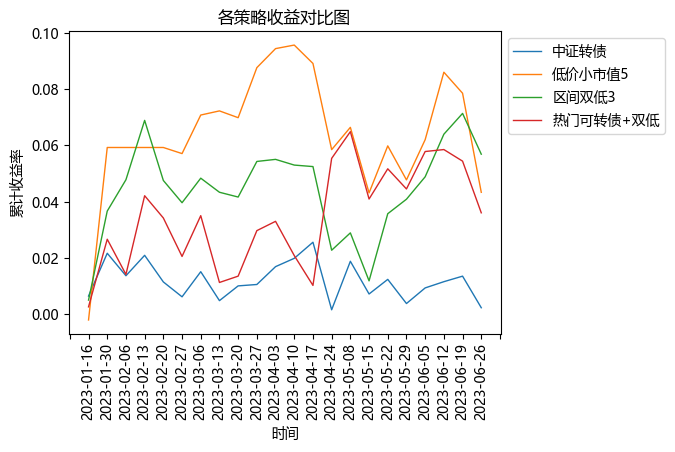

<Figure size 48000x18000 with 0 Axes>

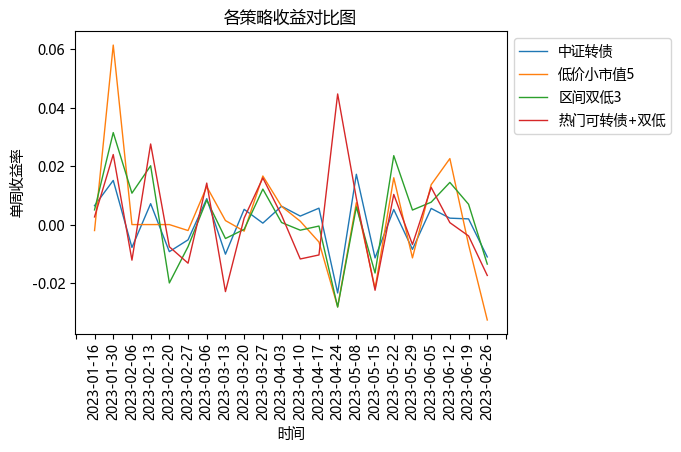

程序运行时间：63.49秒


In [10]:
# 跑1个回测周期,获得多个策略的单周收益率、累计收益率对比图
# 根据需要更改test_day_list回测周期，names策略

test_day_list = [('2022-07-01','2022-12-31'), ('2023-01-01','2023-06-30')]

"""
需要哪些策略的收益对比图，就放进哪些，这样跑的速度快并且结果清晰
names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx', 
         '高ytm（全量数据DTBS，用于回测）.xlsx', 
         '区间双低3（全量数据DTBS，用于回测）.xlsx', 
         '双低5（全量数据DTBS，用于回测）.xlsx', 
         '小市值3双低5（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']
"""

names = ['低价小市值5（全量数据DTBS，用于回测）.xlsx',
         '区间双低3（全量数据DTBS，用于回测）.xlsx',
         '热门可转债+双低（全量数据DTBS，用于回测）.xlsx']


set_which_day = 'mon'
    
start_time = time.time()

for start_day,end_day in test_day_list:    
    profit_dict = {}   
    for name in names: 
              
        # 获得标准化持仓字典        
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)

        # 获得收益率曲线列表    
        profit = get_weekly_return(trade_dates_list,D_DF,A_DF,10000000,my_position,my_current_flag=1)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        strategy_name = str(name[ : name.index('（')])
        profit_dict[strategy_name] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
    display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略收益对比图', tick_spacing = 1) 
    
end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")


 2021-04-26 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}

 2021-04-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-04-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 40.64 , 持仓明细字典: {'123061.SZ': 19520, '128056.SZ': 19520, '113576.SH': 19520, '123102.SZ': 19520, '128074.SZ': 19520}
113576.SH ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调


 2021-06-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 395.96 , 持仓明细字典: {'123011.SZ': 19761, '113601.SH': 19761, '113566.SH': 19761, '113624.SH': 19761, '123080.SZ': 19761}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 395.96 , 持仓明细字典: {'123011.SZ': 19761, '113601.SH': 19761, '113566.SH': 19761, '113624.SH': 19761, '123080.SZ': 19761}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-28 : 今日是调仓日
换仓前, 账户内剩余现金: 395.96 , 持仓明细字典: {'123011.SZ': 19761, '113601.SH': 19761, '113566.SH': 19761, '113624.SH': 19761, '123080.SZ': 19761}
等份额调仓
换仓后, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 20362, '128069.SZ': 20362, '123080.SZ': 20362}

 2021-06-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 20362, '128069.SZ': 20362, '123080.SZ': 20362}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-06-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 65.78 , 持仓明细字典: {'113573.SH': 20362, '123023.SZ': 20362, '128118.SZ': 


 2021-08-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 228.7 , 持仓明细字典: {'123028.SZ': 21056, '128117.SZ': 21056, '113600.SH': 21056, '113578.SH': 21056, '113624.SH': 21056}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-19 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 228.7 , 持仓明细字典: {'123028.SZ': 21056, '128117.SZ': 21056, '113600.SH': 21056, '113578.SH': 21056, '113624.SH': 21056}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 228.7 , 持仓明细字典: {'123028.SZ': 21056, '128117.SZ': 21056, '113600.SH': 21056, '113578.SH': 21056, '113624.SH': 21056}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-08-23 : 今日是调仓日
换仓前, 账户内剩余现金: 228.7 , 持仓明细字典: {'123028.SZ': 21056, '128117.SZ': 21056, '113600.SH': 21056, '113578.SH': 21056, '113624.SH': 21056}
等份额调仓
换仓后, 账户内剩余现金: 113.26 , 持仓明细字典: {'123028.SZ': 21063, '113591.SH': 21063, '128074.SZ': 21063, '113578.SH': 21063, '113624.SH': 21063}

 2021-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 113.26 , 持仓明细字典: {'123028.SZ': 21063, '113591.SH': 21063, '128074.SZ': 2


 2021-10-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 39.07 , 持仓明细字典: {'128066.SZ': 22808, '123106.SZ': 22808, '128070.SZ': 22808, '123082.SZ': 22808, '113546.SH': 22808}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 39.07 , 持仓明细字典: {'128066.SZ': 22808, '123106.SZ': 22808, '128070.SZ': 22808, '123082.SZ': 22808, '113546.SH': 22808}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-25 : 今日是调仓日
换仓前, 账户内剩余现金: 39.07 , 持仓明细字典: {'128066.SZ': 22808, '123106.SZ': 22808, '128070.SZ': 22808, '123082.SZ': 22808, '113546.SH': 22808}
等份额调仓
换仓后, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 23425, '128074.SZ': 23425, '113628.SH': 23425}

 2021-10-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 23425, '128074.SZ': 23425, '113628.SH': 23425}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-10-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 58.62 , 持仓明细字典: {'123056.SZ': 23425, '123126.SZ': 23425, '123093.SZ': 234


 2021-12-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 282.78 , 持仓明细字典: {'113589.SH': 25210, '113519.SH': 25210, '113601.SH': 25210, '128069.SZ': 25210, '113597.SH': 25210}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-20 : 今日是调仓日
换仓前, 账户内剩余现金: 282.78 , 持仓明细字典: {'113589.SH': 25210, '113519.SH': 25210, '113601.SH': 25210, '128069.SZ': 25210, '113597.SH': 25210}
等份额调仓
换仓后, 账户内剩余现金: 28.62 , 持仓明细字典: {'113519.SH': 25209, '123056.SZ': 25209, '128117.SZ': 25209, '113573.SH': 25209, '128118.SZ': 25209}

 2021-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 28.62 , 持仓明细字典: {'113519.SH': 25209, '123056.SZ': 25209, '128117.SZ': 25209, '113573.SH': 25209, '128118.SZ': 25209}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 28.62 , 持仓明细字典: {'113519.SH': 25209, '123056.SZ': 25209, '128117.SZ': 25209, '113573.SH': 25209, '128118.SZ': 25209}
没有转债需要止损/止盈，当日无需重新调仓！

 2021-12-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 28.62 , 持仓明细字典: {'113519.SH': 25209, '123056.SZ': 25209, '128117.SZ': 2


 2022-02-17 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 66.4 , 持仓明细字典: {'128138.SZ': 42708, '128118.SZ': 42708, '113578.SH': 42708}
113578.SH ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 115.46 , 持仓明细字典: {'128138.SZ': 63395, '128118.SZ': 63395}

 2022-02-18 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 115.46 , 持仓明细字典: {'128138.SZ': 63395, '128118.SZ': 63395}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-21 : 今日是调仓日
换仓前, 账户内剩余现金: 115.46 , 持仓明细字典: {'128138.SZ': 63395, '128118.SZ': 63395}
等份额调仓
换仓后, 账户内剩余现金: 215.96 , 持仓明细字典: {'113595.SH': 26071, '113569.SH': 26071, '123044.SZ': 26071, '123093.SZ': 26071, '113573.SH': 26071}

 2022-02-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 215.96 , 持仓明细字典: {'113595.SH': 26071, '113569.SH': 26071, '123044.SZ': 26071, '123093.SZ': 26071, '113573.SH': 26071}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-02-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 215.96 , 持仓明细字典: {'113595.SH': 26071, '113569.SH': 26071, '123044.SZ': 26071, '123093.SZ': 26071, '113573.SH': 26071}
没有转债需要止损/


 2022-04-13 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 447.03 , 持仓明细字典: {'113576.SH': 25490, '113573.SH': 25490, '128074.SZ': 25490, '123093.SZ': 25490, '113628.SH': 25490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-14 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 447.03 , 持仓明细字典: {'113576.SH': 25490, '113573.SH': 25490, '128074.SZ': 25490, '123093.SZ': 25490, '113628.SH': 25490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-15 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 447.03 , 持仓明细字典: {'113576.SH': 25490, '113573.SH': 25490, '128074.SZ': 25490, '123093.SZ': 25490, '113628.SH': 25490}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-18 : 今日是调仓日
换仓前, 账户内剩余现金: 447.03 , 持仓明细字典: {'113576.SH': 25490, '113573.SH': 25490, '128074.SZ': 25490, '123093.SZ': 25490, '113628.SH': 25490}
等份额调仓
换仓后, 账户内剩余现金: 193.1 , 持仓明细字典: {'113569.SH': 26119, '128074.SZ': 26119, '113578.SH': 26119, '113628.SH': 26119, '113584.SH': 26119}


<Figure size 48000x18000 with 0 Axes>

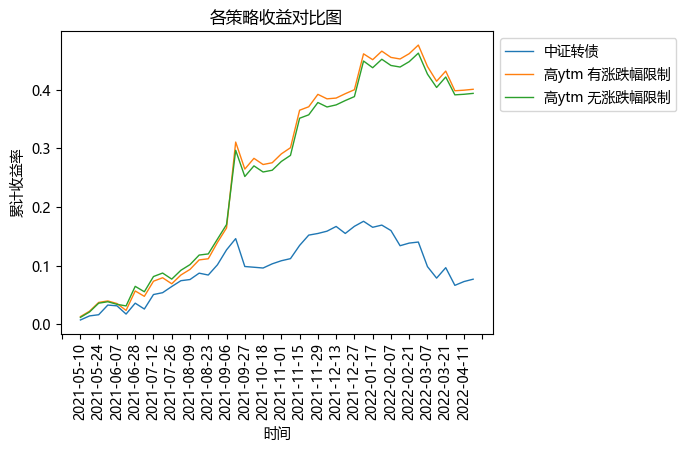

<Figure size 48000x18000 with 0 Axes>

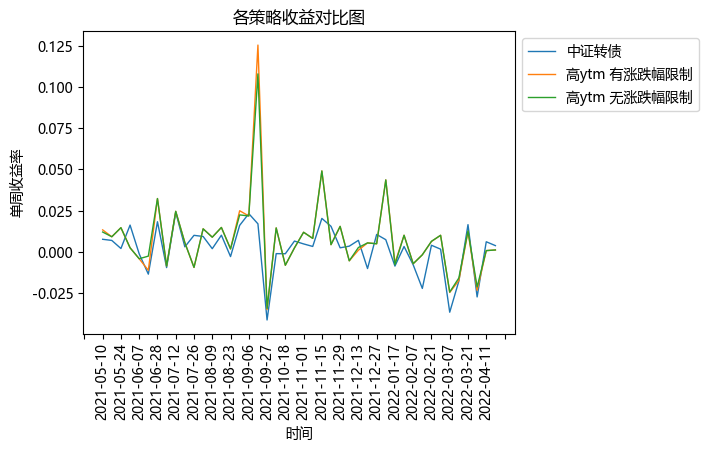


 2022-04-25 : 今日是调仓日
换仓前, 账户内剩余现金: 10000000 , 持仓明细字典: {}
等份额调仓
换仓后, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}

 2022-04-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-04-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 207.42 , 持仓明细字典: {'113569.SH': 18770, '128074.SZ': 18770, '128118.SZ': 18770, '128117.SZ': 18770, '123106.SZ': 18770}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-05-05 : 今日是非调仓日，监


 2022-06-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 389.91 , 持仓明细字典: {'128138.SZ': 25996, '113578.SH': 25996, '113604.SH': 25996, '113573.SH': 25996}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-06-27 : 今日是调仓日
换仓前, 账户内剩余现金: 389.91 , 持仓明细字典: {'128138.SZ': 25996, '113578.SH': 25996, '113604.SH': 25996, '113573.SH': 25996}
等份额调仓
换仓后, 账户内剩余现金: 138.74 , 持仓明细字典: {'128138.SZ': 20843, '113578.SH': 20843, '113604.SH': 20843, '128074.SZ': 20843, '123126.SZ': 20843}

 2022-06-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 138.74 , 持仓明细字典: {'128138.SZ': 20843, '113578.SH': 20843, '113604.SH': 20843, '128074.SZ': 20843, '123126.SZ': 20843}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-06-29 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 138.74 , 持仓明细字典: {'128138.SZ': 20843, '113578.SH': 20843, '113604.SH': 20843, '128074.SZ': 20843, '123126.SZ': 20843}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-06-30 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 138.74 , 持仓明细字典: {'128138.SZ': 20843, '113578.SH': 20843, '113604.SH': 20843, '128074.SZ': 20843, '123126.SZ


 2022-08-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 320.94 , 持仓明细字典: {'113595.SH': 22395, '113589.SH': 22395, '113569.SH': 22395, '113578.SH': 22395, '123126.SZ': 22395}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 320.94 , 持仓明细字典: {'113595.SH': 22395, '113589.SH': 22395, '113569.SH': 22395, '113578.SH': 22395, '123126.SZ': 22395}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-25 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 320.94 , 持仓明细字典: {'113595.SH': 22395, '113589.SH': 22395, '113569.SH': 22395, '113578.SH': 22395, '123126.SZ': 22395}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 320.94 , 持仓明细字典: {'113595.SH': 22395, '113589.SH': 22395, '113569.SH': 22395, '113578.SH': 22395, '123126.SZ': 22395}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-08-29 : 今日是调仓日
换仓前, 账户内剩余现金: 320.94 , 持仓明细字典: {'113595.SH': 22395, '113589.SH': 22395, '113569.SH': 22395, '113578.SH': 22395, '123126.SZ': 22395}
等份额调仓
换仓后, 账户内剩余现金: 117.36 , 持仓明细字典: {'128063.SZ': 21080, '113604.


 2022-10-26 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 231.61 , 持仓明细字典: {'113578.SH': 21866, '113595.SH': 21866, '113576.SH': 21866, '128085.SZ': 21866, '113625.SH': 21866}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-27 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 231.61 , 持仓明细字典: {'113578.SH': 21866, '113595.SH': 21866, '113576.SH': 21866, '128085.SZ': 21866, '113625.SH': 21866}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-10-28 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 231.61 , 持仓明细字典: {'113578.SH': 21866, '113595.SH': 21866, '113576.SH': 21866, '128085.SZ': 21866, '113625.SH': 21866}
113595.SH ：突破当日最大跌幅限制，需要止损。
有转债止损/止盈，当日需要重新调仓！
等份额调仓
换仓后, 账户内剩余现金: 308.45 , 持仓明细字典: {'113578.SH': 27304, '113576.SH': 27304, '128085.SZ': 27304, '113625.SH': 27304}

 2022-10-31 : 今日是调仓日
换仓前, 账户内剩余现金: 308.45 , 持仓明细字典: {'113578.SH': 27304, '113576.SH': 27304, '128085.SZ': 27304, '113625.SH': 27304}
等份额调仓
换仓后, 账户内剩余现金: 487.19 , 持仓明细字典: {'113578.SH': 21965, '113595.SH': 21965, '128085.SZ': 21965, '113604.SH': 21965, '113628.SH': 21965}



 2022-12-20 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 96.26 , 持仓明细字典: {'113576.SH': 21343, '128085.SZ': 21343, '113595.SH': 21343, '123063.SZ': 21343, '123093.SZ': 21343}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 96.26 , 持仓明细字典: {'113576.SH': 21343, '128085.SZ': 21343, '113595.SH': 21343, '123063.SZ': 21343, '123093.SZ': 21343}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 96.26 , 持仓明细字典: {'113576.SH': 21343, '128085.SZ': 21343, '113595.SH': 21343, '123063.SZ': 21343, '123093.SZ': 21343}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 96.26 , 持仓明细字典: {'113576.SH': 21343, '128085.SZ': 21343, '113595.SH': 21343, '123063.SZ': 21343, '123093.SZ': 21343}
没有转债需要止损/止盈，当日无需重新调仓！

 2022-12-26 : 今日是调仓日
换仓前, 账户内剩余现金: 96.26 , 持仓明细字典: {'113576.SH': 21343, '128085.SZ': 21343, '113595.SH': 21343, '123063.SZ': 21343, '123093.SZ': 21343}
等份额调仓
换仓后, 账户内剩余现金: 31.99 , 持仓明细字典: {'113595.SH': 21972, '113601.SH': 2


 2023-02-21 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 481.41 , 持仓明细字典: {'128085.SZ': 22427, '113576.SH': 22427, '113569.SH': 22427, '113595.SH': 22427, '113601.SH': 22427}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-22 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 481.41 , 持仓明细字典: {'128085.SZ': 22427, '113576.SH': 22427, '113569.SH': 22427, '113595.SH': 22427, '113601.SH': 22427}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-23 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 481.41 , 持仓明细字典: {'128085.SZ': 22427, '113576.SH': 22427, '113569.SH': 22427, '113595.SH': 22427, '113601.SH': 22427}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-24 : 今日是非调仓日，监控实时盈亏, 进行止损止盈操作。
换仓前, 账户内剩余现金: 481.41 , 持仓明细字典: {'128085.SZ': 22427, '113576.SH': 22427, '113569.SH': 22427, '113595.SH': 22427, '113601.SH': 22427}
没有转债需要止损/止盈，当日无需重新调仓！

 2023-02-27 : 今日是调仓日
换仓前, 账户内剩余现金: 481.41 , 持仓明细字典: {'128085.SZ': 22427, '113576.SH': 22427, '113569.SH': 22427, '113595.SH': 22427, '113601.SH': 22427}
等份额调仓
换仓后, 账户内剩余现金: 107.21 , 持仓明细字典: {'128085.SZ': 22101, '113595.

<Figure size 48000x18000 with 0 Axes>

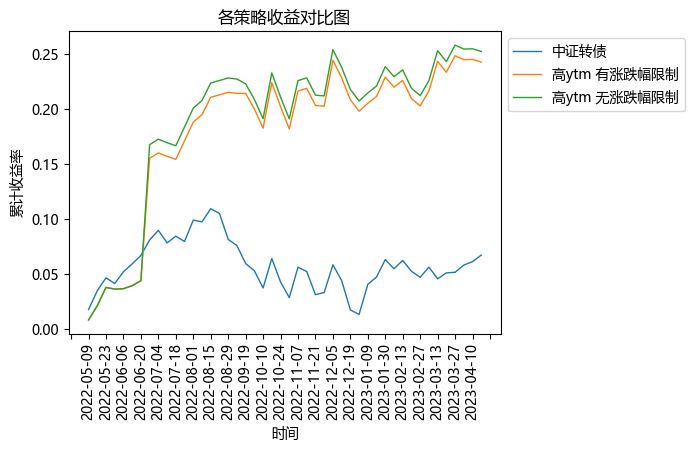

<Figure size 48000x18000 with 0 Axes>

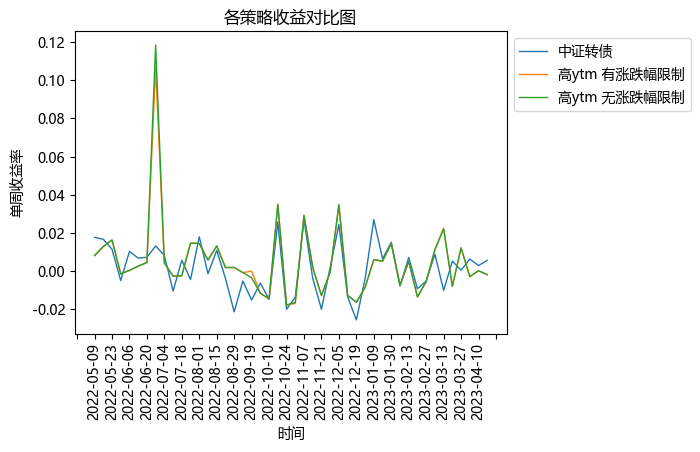

程序运行时间：48.33秒


In [11]:
# 对比设/不设涨跌幅限制的收益率曲线

test_day_list = [('2021-04-20','2022-04-19'), ('2022-04-20','2023-04-19')]

names = ['高ytm（全量数据DTBS，用于回测）.xlsx']

set_which_day = 'mon'

start_time = time.time()
          
for start_day,end_day in test_day_list:    
    profit_dict = {}   
    for name in names: 
        
        strategy_name = str(name[ : name.index('（')])
              
        # 获得标准化持仓字典
        my_position,trade_dates_list = get_my_position(name, start_day, end_day, which_day, D_DF)

        # 获得收益率曲线列表    
        profit = get_weekly_return(trade_dates_list,D_DF,A_DF,10000000,my_position,my_current_flag=1)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        
        profit_dict[strategy_name + ' 有涨跌幅限制'] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
        # 获得收益率曲线列表    
        profit = get_period_profit(trade_dates_list, my_position, A_DF)

        # 获取各类收益率
        weekly_return, cumulative_return, zi_weekly_return, zi_cumulative_return = get_all_profit(profit, trade_dates_list, C_DF , photo_title = name[ : name.index('（')], tick_spacing = 1)
        
        profit_dict[strategy_name + ' 无涨跌幅限制'] = {'weekly_return' : weekly_return, 
                                      'cumulative_return' : cumulative_return}
        
    display_multiple_strategies(profit_dict, trade_dates_list, zi_weekly_return, zi_cumulative_return, photo_title = '各策略收益对比图', tick_spacing = 2)

end_time = time.time()
run_time = end_time - start_time
# 输出运行时间
print(f"程序运行时间：{run_time:.2f}秒")
